*Author:* **Javier Jordán Luque** (Software & AI Engineer)

# Electric Demand Predictor Analysis
___

### Import libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import os
import joblib

### Read dataset

In [2]:
filename = 'data/Registro_Potencias_EII_30_Septiembre_2021_a_30_Septiembre_2022.xlsx'
data = pd.read_excel(
    filename,
    header=0,
    engine="openpyxl"
)

data.head()

,Day,Month,Year,Hour,Quarter,(kW),(kVAr)
0,30,9,2021,0,1,240,48
1,30,9,2021,0,2,248,56
2,30,9,2021,0,3,240,48
3,30,9,2021,0,4,236,48
4,30,9,2021,1,1,228,52


### Add new variables

#### - Day_week

In [3]:
data["date"] = pd.to_datetime(data[["Year", "Month", "Day"]])

def get_day_week(date):
    return date.weekday()

data["Day_week"] = data["date"].apply(get_day_week)

data.head()

,Day,Month,Year,Hour,Quarter,(kW),(kVAr),date,Day_week
0,30,9,2021,0,1,240,48,2021-09-30,3
1,30,9,2021,0,2,248,56,2021-09-30,3
2,30,9,2021,0,3,240,48,2021-09-30,3
3,30,9,2021,0,4,236,48,2021-09-30,3
4,30,9,2021,1,1,228,52,2021-09-30,3


#### - Season

In [4]:
def get_season(date):
    month = date.month
    dia = date.day
    if (month == 3 and dia >= 20) or month in [4, 5] or (month == 6 and dia < 21):
        return 0 # Spring
    elif (month == 6 and dia >= 21) or month in [7, 8] or (month == 9 and dia < 23):
        return 1 # Summer
    elif (month == 9 and dia >= 23) or month in [10, 11] or (month == 12 and dia < 21):
        return 2 # Autumn
    else:
        return 3 # Winter

data["Season"] = data["date"].apply(get_season)

data.drop(columns=["date"], inplace=True)

data.head()

,Day,Month,Year,Hour,Quarter,(kW),(kVAr),Day_week,Season
0,30,9,2021,0,1,240,48,3,2
1,30,9,2021,0,2,248,56,3,2
2,30,9,2021,0,3,240,48,3,2
3,30,9,2021,0,4,236,48,3,2
4,30,9,2021,1,1,228,52,3,2


___
## EDA (Exploratory Data Analysis)

### Number of instances

In [5]:
dataset_size = data.shape[0]
print("Number of instances:", dataset_size)

Number of instances: 26304


### Variable data types

In [6]:
type_values = data.dtypes
pd.DataFrame({
    "Variables": type_values.index,
    "Data type": type_values.values
})

,Variables,Data type
0,Day,int64
1,Month,int64
2,Year,int64
3,Hour,int64
4,Quarter,int64
5,(kW),int64
6,(kVAr),int64
7,Day_week,int64
8,Season,int64


### Statistical metrics

In [7]:
data.describe()

,Day,Month,Year,Hour,Quarter,(kW),(kVAr),Day_week,Season
count,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000
mean,15.734185,6.044860,2021.660432,11.503345,2.500000,336.117701,14.822689,3.000000,1.609793
std,8.803777,3.832198,0.473572,6.923042,1.118055,123.118824,65.896119,1.996385,1.251466
min,1.000000,1.000000,2021.000000,0.000000,1.000000,12.000000,-120.000000,0.000000,0.000000
25%,8.000000,3.000000,2021.000000,6.000000,1.750000,240.000000,-60.000000,1.000000,0.000000
50%,16.000000,5.000000,2022.000000,12.000000,2.500000,276.000000,56.000000,3.000000,2.000000
75%,23.000000,10.000000,2022.000000,18.000000,3.250000,432.000000,68.000000,5.000000,3.000000
max,31.000000,12.000000,2022.000000,24.000000,4.000000,856.000000,116.000000,6.000000,3.000000


### (kW) and (kVAr) variable distribution

#### - Distribution by Day

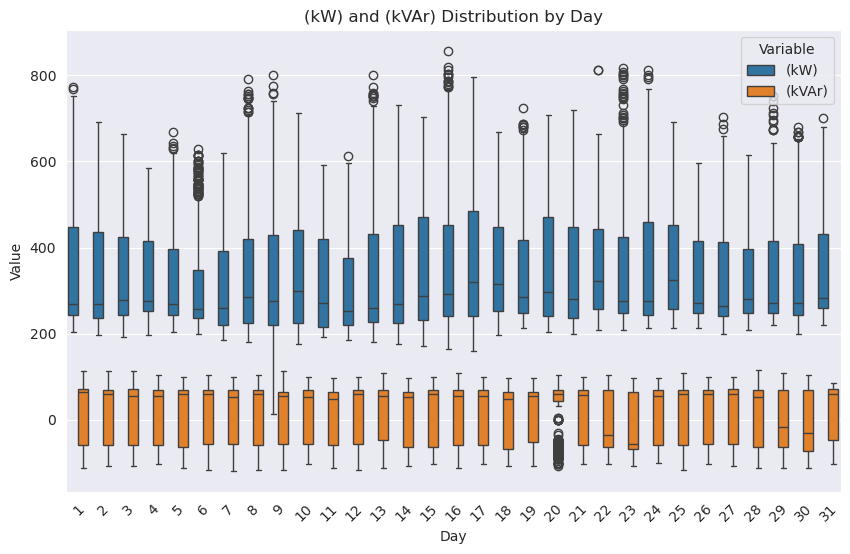

In [8]:
df_long = data.melt(id_vars=["Day"], value_vars=["(kW)", "(kVAr)"],
                    var_name="Variable", value_name="Value")

plt.figure(figsize=(10, 6))
sns.boxplot(x="Day", y="Value", hue="Variable", data=df_long)
plt.xticks(rotation=45)
plt.title("(kW) and (kVAr) Distribution by Day")
plt.legend(title="Variable")
plt.show()

#### - Distribution by Month

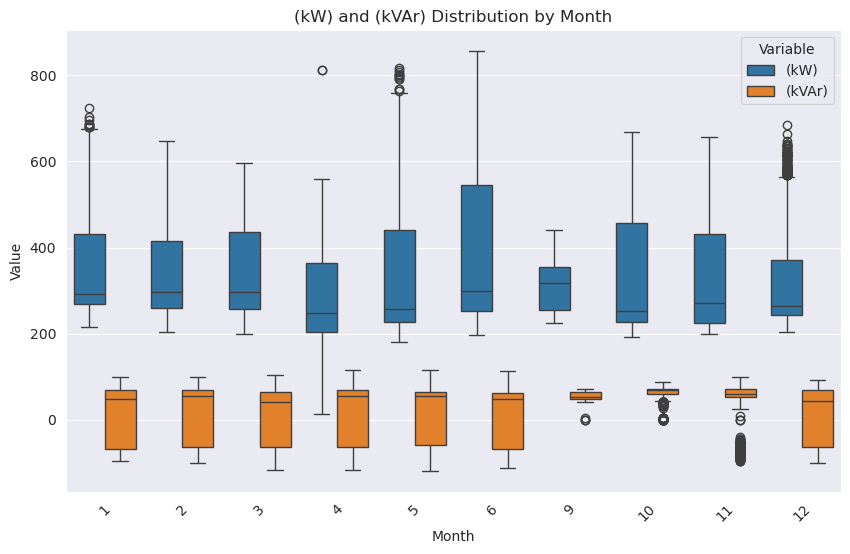

In [9]:
df_long = data.melt(id_vars=["Month"], value_vars=["(kW)", "(kVAr)"],
                    var_name="Variable", value_name="Value")

plt.figure(figsize=(10, 6))
sns.boxplot(x="Month", y="Value", hue="Variable", data=df_long)
plt.xticks(rotation=45)
plt.title("(kW) and (kVAr) Distribution by Month")
plt.legend(title="Variable")
plt.show()

#### - Distribution by Year

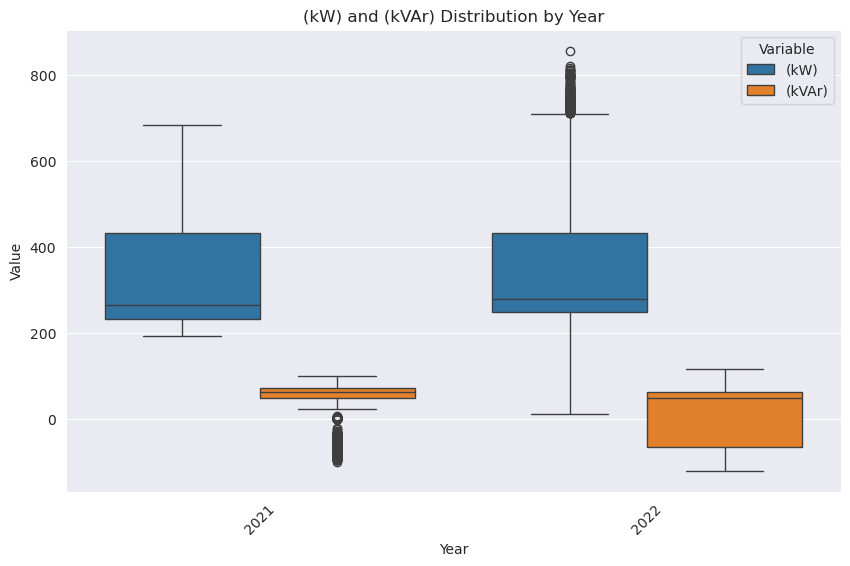

In [10]:
df_long = data.melt(id_vars=["Year"], value_vars=["(kW)", "(kVAr)"],
                    var_name="Variable", value_name="Value")

plt.figure(figsize=(10, 6))
sns.boxplot(x="Year", y="Value", hue="Variable", data=df_long)
plt.xticks(rotation=45)
plt.title("(kW) and (kVAr) Distribution by Year")
plt.legend(title="Variable")
plt.show()

#### - Distribution by Hour

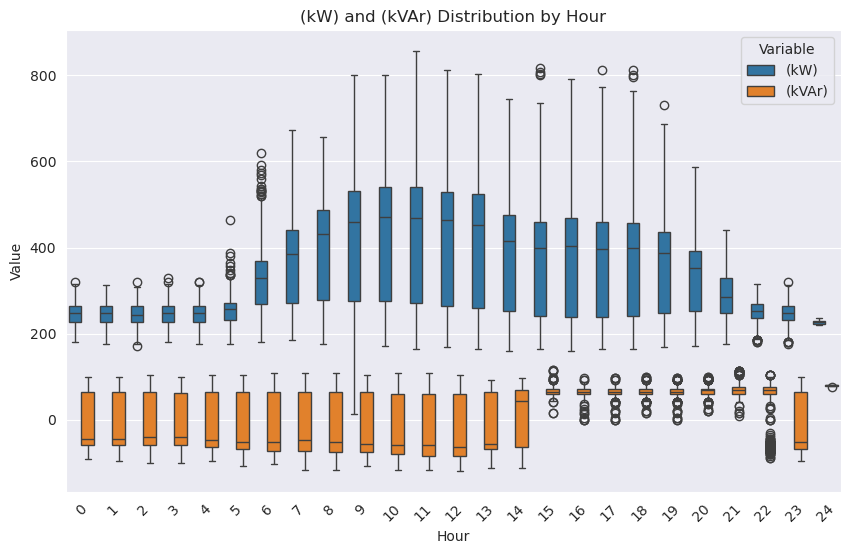

In [11]:
df_long = data.melt(id_vars=["Hour"], value_vars=["(kW)", "(kVAr)"],
                    var_name="Variable", value_name="Value")

plt.figure(figsize=(10, 6))
sns.boxplot(x="Hour", y="Value", hue="Variable", data=df_long)
plt.xticks(rotation=45)
plt.title("(kW) and (kVAr) Distribution by Hour")
plt.legend(title="Variable")
plt.show()

#### - Distribution by Quarter

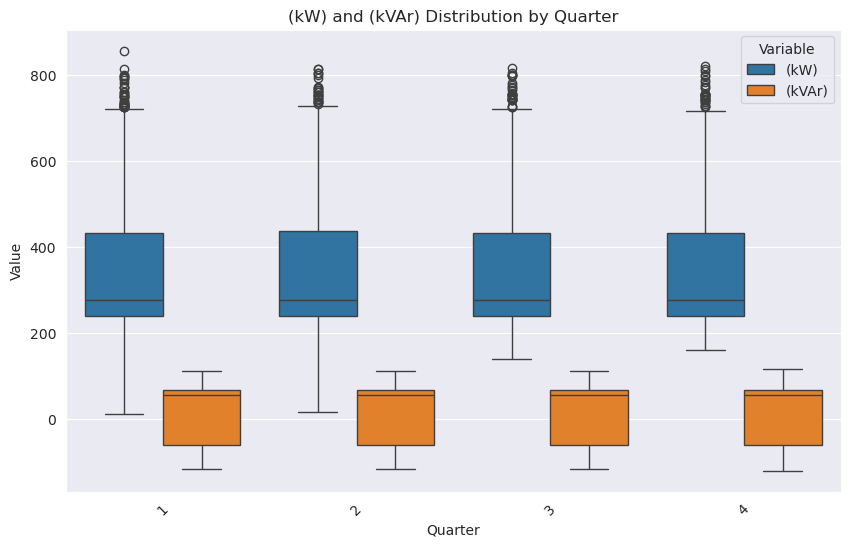

In [12]:
df_long = data.melt(id_vars=["Quarter"], value_vars=["(kW)", "(kVAr)"],
                    var_name="Variable", value_name="Value")

plt.figure(figsize=(10, 6))
sns.boxplot(x="Quarter", y="Value", hue="Variable", data=df_long)
plt.xticks(rotation=45)
plt.title("(kW) and (kVAr) Distribution by Quarter")
plt.legend(title="Variable")
plt.show()

#### - Distribution by Day_week

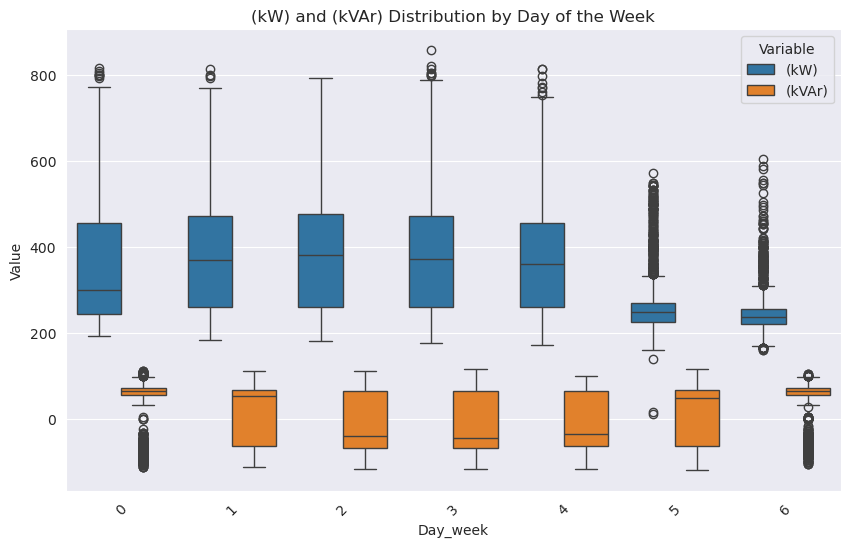

In [13]:
df_long = data.melt(id_vars=["Day_week"], value_vars=["(kW)", "(kVAr)"],
                    var_name="Variable", value_name="Value")

plt.figure(figsize=(10, 6))
sns.boxplot(x="Day_week", y="Value", hue="Variable", data=df_long)
plt.xticks(rotation=45)
plt.title("(kW) and (kVAr) Distribution by Day of the Week")
plt.legend(title="Variable")
plt.show()

#### - Distribution by Season

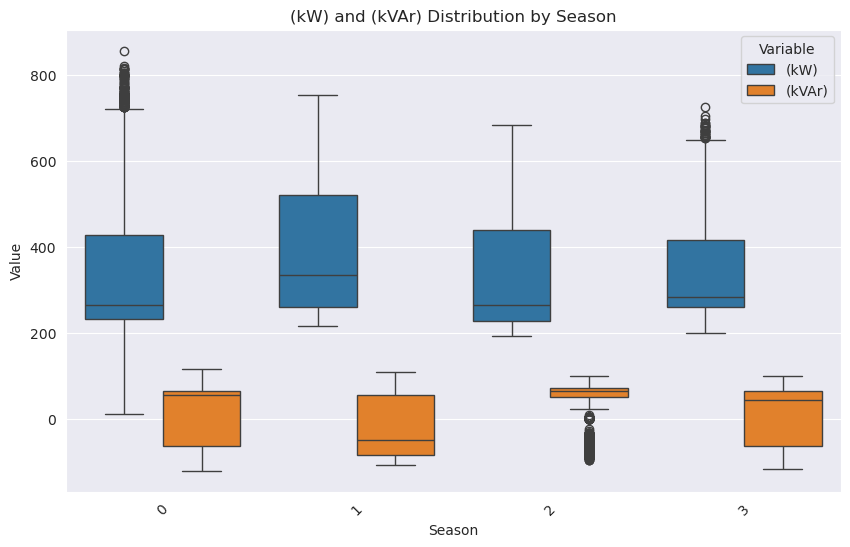

In [14]:
df_long = data.melt(id_vars=["Season"], value_vars=["(kW)", "(kVAr)"],
                    var_name="Variable", value_name="Value")

plt.figure(figsize=(10, 6))
sns.boxplot(x="Season", y="Value", hue="Variable", data=df_long)
plt.xticks(rotation=45)
plt.title("(kW) and (kVAr) Distribution by Season")
plt.legend(title="Variable")
plt.show()

### Null values

In [15]:
print("Null values:", data.isnull().sum().sum())

Null values: 0


### Outliers

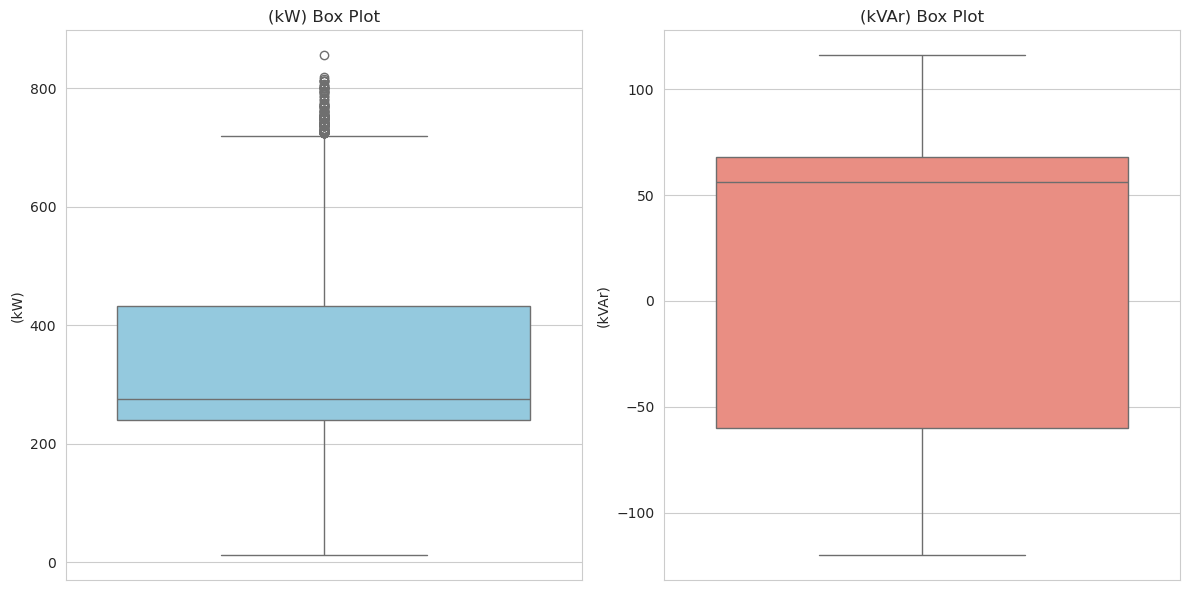

In [16]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(y=data["(kW)"], ax=axes[0], color="skyblue")
axes[0].set_title("(kW) Box Plot")
axes[0].set_ylabel("(kW)")

sns.boxplot(y=data["(kVAr)"], ax=axes[1], color="salmon")
axes[1].set_title("(kVAr) Box Plot")
axes[1].set_ylabel("(kVAr)")

plt.tight_layout()
plt.show()

___
## Preprocessing

In [17]:
ordered_columns = ["Day", "Month", "Year", "Hour", "Quarter", "Day_week", "Season", "(kW)", "(kVAr)"]
data = data[ordered_columns]

print(data.head())

   Day  Month  Year  Hour  Quarter  Day_week  Season  (kW)  (kVAr)
0   30      9  2021     0        1         3       2   240      48
1   30      9  2021     0        2         3       2   248      56
2   30      9  2021     0        3         3       2   240      48
3   30      9  2021     0        4         3       2   236      48
4   30      9  2021     1        1         3       2   228      52


### Outliers

#### - Outliers in predictor variables: Day, Month, Year, Hour, Quarter, Day_week and Season

In [18]:
valid_ranges = {
    "Day": (1, 31),
    "Month": (1, 12),
    "Year": (data["Year"].min(), data["Year"].max()),
    "Hour": (0, 23),
    "Quarter": (1, 4),
    "Day_week": (0, 6),
    "Season": (0, 3)
}

outliers = {}
for col, (min_val, max_val) in valid_ranges.items():
    outliers[col] = data[(data[col] < min_val) | (data[col] > max_val)][col]

outliers_count = {col: values.count() for col, values in outliers.items()}

pd.DataFrame(list(outliers_count.items()), columns=["Variable", "Number of Outliers"])

,Variable,Number of Outliers
0,Day,0
1,Month,0
2,Year,0
3,Hour,4
4,Quarter,0
5,Day_week,0
6,Season,0


In [19]:
for col, (min_val, max_val) in valid_ranges.items():
    data = data[(data[col] >= min_val) & (data[col] <= max_val)]

data.reset_index(drop=True, inplace=True)
dataset_size_cleaned = data.shape[0]

print(f"Original dataset size: {dataset_size} rows")
print(f"Cleaned dataset size: {dataset_size_cleaned} rows")
print(f"Total rows removed: {dataset_size - dataset_size_cleaned}")

Original dataset size: 26304 rows
Cleaned dataset size: 26300 rows
Total rows removed: 4


#### - Outliers in objetive variables: (kW) and (kVAr)

In [20]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outliers_kw = detect_outliers_iqr(data, "(kW)")
outliers_kvar = detect_outliers_iqr(data, "(kVAr)")

pd.DataFrame({
    "Variable": ["(kW)", "(kVAr)"],
    "Number of Outliers": [outliers_kw.shape[0], outliers_kvar.shape[0]]
})

,Variable,Number of Outliers
0,(kW),127
1,(kVAr),0


In [21]:
outliers_index = set(outliers_kw.index).union(set(outliers_kvar.index))
data.drop(index=outliers_index, inplace=True)
data.reset_index(drop=True, inplace=True)

print(f"Original dataset size: {dataset_size_cleaned} rows")
print(f"Cleaned dataset size: {data.shape[0]} rows")
print(f"Total rows removed: {dataset_size_cleaned - data.shape[0]}")

Original dataset size: 26300 rows
Cleaned dataset size: 26173 rows
Total rows removed: 127


___
## Random Forest Regressor

In [22]:
X = data.drop(columns=["(kW)", "(kVAr)"])
y = data[["(kW)", "(kVAr)"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=13)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (20938, 7), (20938, 2)
Test set: (5235, 7), (5235, 2)


### Model training

In [23]:
rf = RandomForestRegressor(random_state=13)

param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}

grid_search = GridSearchCV(
    rf, param_grid, cv=10, scoring="r2", n_jobs=-1, verbose=1
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best R² score: {grid_search.best_score_:.4f}")

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best R² score: 0.9827


### Feature importance

In [24]:
importances = best_rf.feature_importances_
feature_names = X_train.columns

pd.DataFrame({
    "Variable": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

,Variable,Importance
0,Hour,0.433250
1,Day_week,0.224429
2,Month,0.145456
3,Day,0.139958
4,Season,0.031583
5,Year,0.017854
6,Quarter,0.007470


### Model Validation

In [25]:
y_pred_test = best_rf.predict(X_test)

metrics_df = pd.DataFrame(columns=["Variable", "MAE", "MSE", "R²"])

for i, var in enumerate(["(kW)", "(kVAr)"]):
    metrics_df.loc[i] = [
        var,
        mean_absolute_error(y_test.iloc[:, i], y_pred_test[:, i]),
        mean_squared_error(y_test.iloc[:, i], y_pred_test[:, i]),
        r2_score(y_test.iloc[:, i], y_pred_test[:, i])
    ]

metrics_df

,Variable,MAE,MSE,R²
0,(kW),9.658493,224.271928,0.984457
1,(kVAr),5.967511,73.753198,0.983003


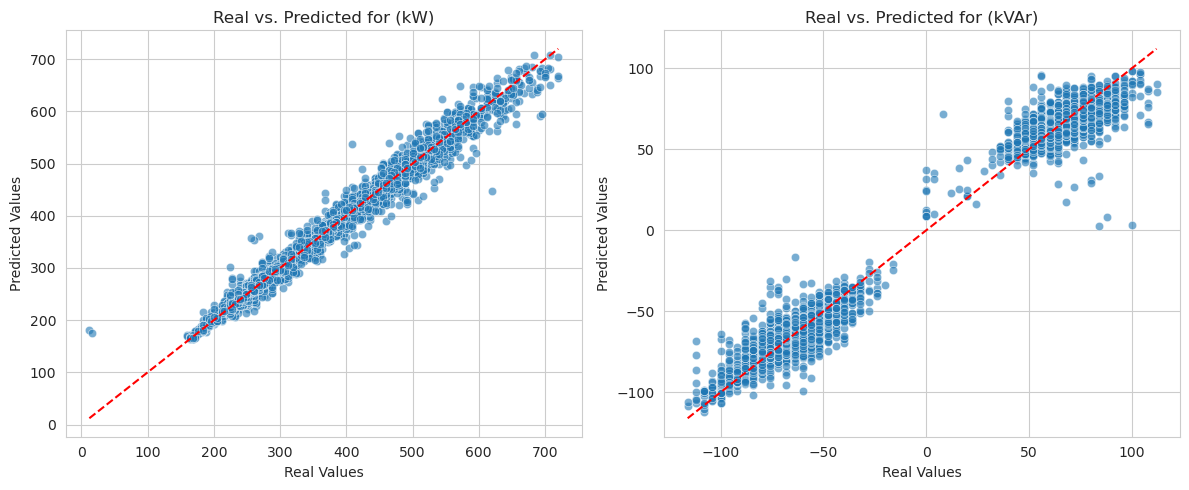

In [26]:
plt.figure(figsize=(12, 5))

variables = ["(kW)", "(kVAr)"]

for i, var in enumerate(variables):
    plt.subplot(1, 2, i + 1)
    sns.scatterplot(x=y_test.iloc[:, i], y=y_pred_test[:, i], alpha=0.6)
    plt.plot(
        [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()],
        [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()],
        color="red",
        linestyle="--",
    )
    plt.xlabel("Real Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Real vs. Predicted for {var}")

plt.tight_layout()
plt.show()

___
## Save Model

In [27]:
os.makedirs("model", exist_ok=True)
joblib.dump(best_rf, "model/random_forest_model.pkl")

['model/random_forest_model.pkl']

___
## Playground

In [28]:
new_example = pd.DataFrame([{
    "Day": 21,
    "Month": 3,
    "Year": 2025,
    "Hour": 13,
    "Quarter": 2,
    "Day_week": 4,
    "Season": 0,
}])

predicted_values = best_rf.predict(new_example)

pd.DataFrame(
    predicted_values.reshape(1, -1).T,
    columns=["Predicted Value"],
    index=["(kW)", "(kVAr)"]
).reset_index().rename(columns={"index": "Variable"})

,Variable,Predicted Value
0,(kW),494.106667
1,(kVAr),-65.813333
